In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.random import randn
from scipy.stats import norm
from scipy.optimize import curve_fit
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

def MSD(t,D,V,taur):                    #Calculate the steplength
    return np.sqrt(4*D*t+V**2*taur**2/2*(2*t/taur+np.exp(-2*t/taur)-1))

plt.rcParams.update({'font.size': 14})

## In this Notebook I try to find out what is the average velocity of an active particle with a certain velocity v, reorientationt time tau_R and dt projected in the parallel direction of the original pointing direction

The numerical simulation of the active particle movement is motivated by this script:

https://github.com/Molecular-Nanophotonics/Photon-Nudging/blob/master/Photon%20Nudging.ipynb

In [2]:
# rotate a 2D vector xy by an angle radians
def rotate(xy, radians):
    x, y = xy
    c, s = np.cos(radians), np.sin(radians)
    j = np.matrix([[c, s], [-s, c]])
    m = np.dot(j, [x, y])

    return(float(m.T[0]), float(m.T[1]))

# generate the data of an active particle random walk
def genData_ap(N,_D,_Dr,_v,dt):
    v=np.random.random(2)
    v[0]=_v
    v[1]=0
    sigma=np.sqrt(2*_D*dt)
    sigma_r=np.sqrt(2*_Dr*dt)

    phi=sigma_r*randn(N).cumsum()
    vx,vy=[np.zeros(N),np.zeros(N)]
    vx[:],vy[:]=[v[0],v[1]]
    vv=np.array([rotate([vx[i],vy[i]],phi[i]) for i in range(len(phi))])

    #do the random walk
    x,y=[(sigma*randn(N)+vv[:,0]*dt).cumsum(),(sigma*randn(N)+vv[:,1]*dt).cumsum()]    

    index=[i for i in range(N)]
    df=pd.DataFrame({'x':x,'y':y,'area':np.zeros(N),'max_intensity':np.zeros(N),'frame': index,'angle': phi})
    return(df)

## Create fitting routine

In [200]:
def deltax(t,A,B):
    return A*v*taur*(1-np.exp(-B*t/taur))

def velocity(t,A,B):
    return A*v*np.exp(-B*t/taur)

## Create a trajectory of  N=100000 for different reorientation time. Then calculate the average length of the step projected in the parallel direction

In [201]:
    #'''
    length = 150
    savedata2 = np.zeros((length,3))
    savedata2[:,0] = np.linspace(0,0.05*length,length)

    
    dt=0.05#savedata2[i,0]#0.05  # 50 ms time resolution
    v= 6#savedata2[i,0]#6   # 10 µm/s velocity
    D=3.85e-14*1e12#   # µm^2/s diffusion coefficient
    taur = 2
    Dr=1/taur#1/savedata[i,0]#1/0.65#D_R(1e-3,0.5e-6)   #  rad^2/s rotational diffusion
    N=200000 # number of steps

    # generate the trajectory and store it in a Pandas DataFrame
    dff=genData_ap(N,D,Dr,v,dt)

    for k in range(1,length):
        #print(k)
        # generate a list of unit vectors in the direction of the particle velocity
        uvec_par=np.array([np.cos(dff.angle),-np.sin(dff.angle)])[:,:-k] 
        
        # generate a list of displacement vectors
        dr=np.array([dff.x.diff(k).dropna().values,dff.y.diff(k).dropna().values])

        # project the displacements on the unit vectors along the propulsion direction
        proj_par=np.sum(uvec_par*dr,axis=0)

        savedata2[k,1] = np.mean(proj_par)
    #'''

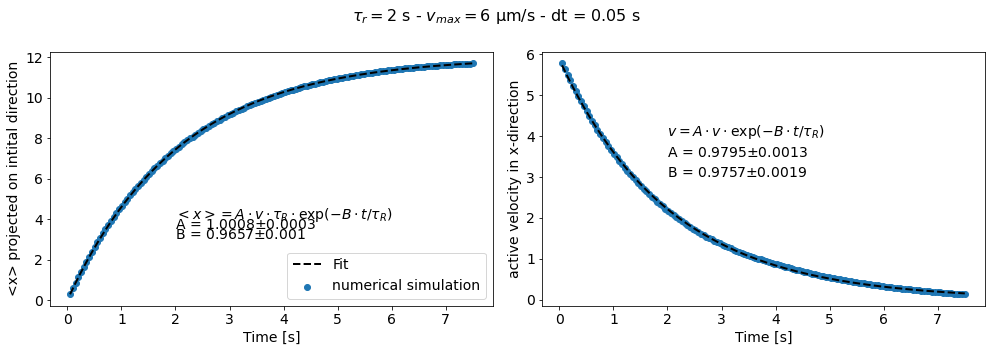

In [203]:
savedata2[:,2] = np.gradient(savedata2[:,1],dt)

fig, ax = plt.subplots(figsize=(14,5)) 
fig.suptitle(r'$\tau_{r} = $'+str(taur)+' s - $v_{max} = $'+str(v)+' µm/s - dt = '+str(dt)+' s', fontsize=16)
ax1 = plt.subplot(1,2,1)
ax1.scatter(savedata2[1:,0],savedata2[1:,1],label='numerical simulation')
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('<x> projected on intital direction') 

popt,pcov = curve_fit(deltax,savedata2[1:,0], savedata2[1:,1],p0 = (1,1))
pErr = np.sqrt(np.diag(pcov))
plt.plot(savedata2[1:,0],deltax(savedata2[1:,0],*popt),color='k',linestyle='--',label='Fit',linewidth=2)
plt.text(2,4,r'$< x > = A \cdot v \cdot \tau_{R} \cdot \exp ( -B\cdot t / \tau_{R} )$')
plt.text(2,3.5,r'A = '+str(round(popt[0],4))+'$\pm$'+str(round(pErr[0],4)),size=14)
plt.text(2,3,r'B = '+str(round(popt[1],4))+'$\pm$'+str(round(pErr[1],4)),size=14)
plt.legend()

#plt.plot(savedata2[1:,0],deltax2(savedata2[1:,0],1,1),color='k',linestyle='--',label='Fit',linewidth=2)

ax1 = plt.subplot(1,2,2)
ax1.scatter(savedata2[1:,0],savedata2[1:,2],label='numerical simulation')
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('active velocity in x-direction') 

popt,pcov = curve_fit(velocity,savedata2[1:,0], savedata2[1:,2],p0 = (1,1))
pErr = np.sqrt(np.diag(pcov))
plt.plot(savedata2[1:,0],velocity(savedata2[1:,0],*popt),color='k',linestyle='--',linewidth=2)
plt.text(2,4,r'$v = A \cdot v \cdot \exp ( -B\cdot t / \tau_{R})$')
plt.text(2,3.5,r'A = '+str(round(popt[0],4))+'$\pm$'+str(round(pErr[0],4)),size=14)
plt.text(2,3,r'B = '+str(round(popt[1],4))+'$\pm$'+str(round(pErr[1],4)),size=14)

plt.tight_layout() 
plt.savefig('Find Active Velocity.pdf', format='pdf')
plt.savefig('Find Active Velocity.svg', format='svg')
plt.show()